## First analysis of FP generator results

In [1]:
import sys
sys.path.insert(1,'../../../../libs')
sys.path.insert(1,'../py')

import pandas as pd
import numpy as np
import random
import standard_atmosphere as sa
import unit_conversions as uc
import utilities as u
import mysql_database as mysql
import airspace_particularities as ap
import geo_tools as gt
import fp_generator_functions as fgf
import matplotlib.pyplot as plt

import importlib
importlib.reload(mysql)
importlib.reload(u)
importlib.reload(fgf)

import configparser



local = 0

if local==0:
    hostname = '10.20.200.133'
    port     = 3306
    hostname = '10.20.198.170'
    password = 'IamLuisIswear'
else:
    hostname = '127.0.0.1'
    port     = 3306
    password = 'UoWaero'
    
username = 'luis'
database_ddr = 'airac_ddr_test'
database_vista = 'vistaenvironment'
database_bada3 = 'bada3'
database_bada4_1 = 'bada4'
database_bada4_2 = 'bada4_2'

scenario_id = 1

mysql_vista = mysql.DataAccessVista(hostname,port,username,password,database_vista)



In [2]:
#READ FLIGHT SELECTED AND NUMBER OF OPTIONS PER FLIGHT AVAILABLE
fs = mysql_vista.read_flights_selected(only_first_preference=True, limit_fields=True, 
                                       other_condition="fs.FPS_run>=61")
foptions = mysql_vista.read_number_options_per_schedule()
fs = pd.merge(fs, foptions, on="schedule_id", how="left")

In [3]:
#CHECK WHICH SCENARIOS THERE ARE IN THE READ DATA
fs[['scenario']].drop_duplicates()

,scenario
0,0
271580,4
543160,5
814740,6
1086320,7
1357900,28
1629480,29


In [ ]:
fs

## BOXPLOTS OF SOME METRICS

In [ ]:
#PLOT INFO IN BOXPLOTS
def plot_in_boxplot(fs,indicator,xlabels=None,ylabel="",title="",figsize=None,ylim=None):
    boxprops = dict(linestyle='-', linewidth=2, color='b')
    medianprops = dict(linestyle='-', linewidth=2, color='r')
    flierprops  = dict(color='#e7298a', alpha=0.5)
    flierprops={'alpha':0.8, 
                'markersize': 5,
                'markeredgecolor': 'None',
                'color': '#e7298a',
                'marker': 'o'
                }
    if figsize is None:
        figsize = [10,5]
    
    values = []
    scenarios = []
    for name, group in fs[['scenario',indicator]].groupby('scenario'):
        values = values + [group[indicator].tolist()]
        scenarios = scenarios + [name]
          
    # Multiple box plots on one Axes
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(values,sym='m.',showmeans=True,
                    boxprops=boxprops,medianprops=medianprops,flierprops=flierprops)
    
    ax.set_xlim([0,len(fs['scenario'].drop_duplicates())+1])
    if ylim is not None:
        ax.set_ylim(ylim)
        
    if xlabels is not None:
        xlab=[]
        for s in scenarios:
            xlab= xlab + [xlabels.get(s)]
            
    else:
        xlab = scenarios
    ax.set_xticklabels(xlab)
        
    plt.title(title)
    plt.suptitle("")
    plt.xlabel("scenario")
    plt.ylabel(ylabel)
    
    plt.show()
    
dict_scenarios={0:'baseline',4:'low fuel',5:'high fuel',6:'FABs',7:'Homogenous',28:'very high fuel'}
    
plot_in_boxplot(fs,'fp_distance_nm',dict_scenarios,'NM','FP distance',ylim=None)
plot_in_boxplot(fs[fs['num_options']>10],'fp_distance_nm',dict_scenarios,'NM','FP distance more than one option',ylim=None)
plot_in_boxplot(fs,'schedule_buffer_min',dict_scenarios,'minutes','buffer',ylim=None)
plot_in_boxplot(fs,'fuel_cost_EUR',dict_scenarios,'EUR','fuel cost',ylim=None)
plot_in_boxplot(fs,'fuel_cost_EUR',dict_scenarios,'EUR','fuel cost',ylim=[-100,15000])
plot_in_boxplot(fs,'crco_cost_EUR',dict_scenarios,'EUR','CRCO cost',ylim=None)
plot_in_boxplot(fs[fs['num_options']>10],'crco_cost_EUR',dict_scenarios,'EUR','CRCO cost more than one option',ylim=None)





In [ ]:
dict_scenarios={0:'baseline',4:'low fuel',5:'high fuel',6:'FABs',7:'Homogenous',28:'very high fuel'}
    
plot_in_boxplot(fs,'fp_distance_nm',dict_scenarios,'NM','FP distance',ylim=None)
plot_in_boxplot(fs[fs['num_options']>10],'fp_distance_nm',dict_scenarios,'NM','FP distance more than one option',ylim=None)
plot_in_boxplot(fs,'schedule_buffer_min',dict_scenarios,'minutes','buffer',ylim=None)
plot_in_boxplot(fs,'fuel_cost_EUR',dict_scenarios,'EUR','fuel cost',ylim=None)
plot_in_boxplot(fs,'fuel_cost_EUR',dict_scenarios,'EUR','fuel cost',ylim=[-100,15000])
plot_in_boxplot(fs,'crco_cost_EUR',dict_scenarios,'EUR','CRCO cost',ylim=None)
plot_in_boxplot(fs[fs['num_options']>10],'crco_cost_EUR',dict_scenarios,'EUR','CRCO cost more than one option',ylim=None)




## LINEAL PLOTS OF METRICS

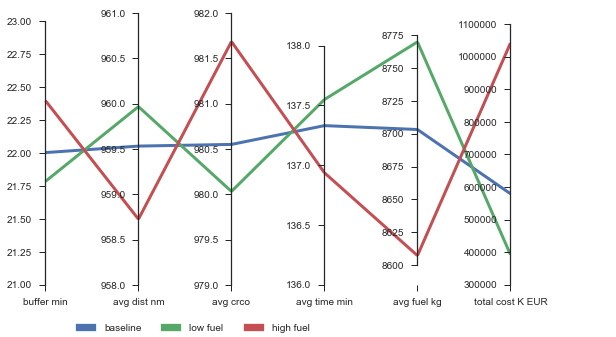

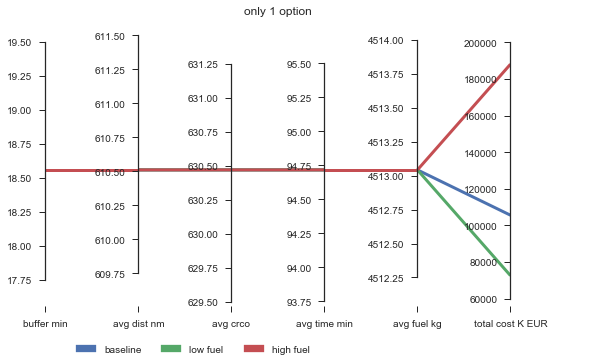

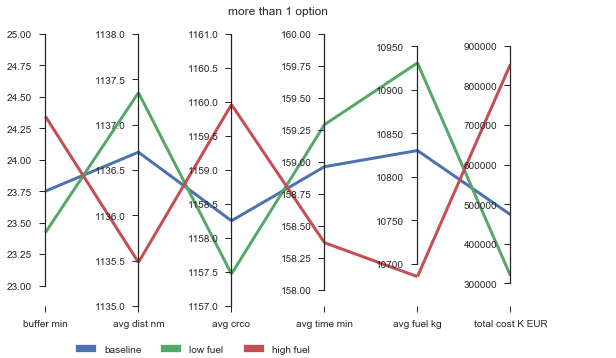

120


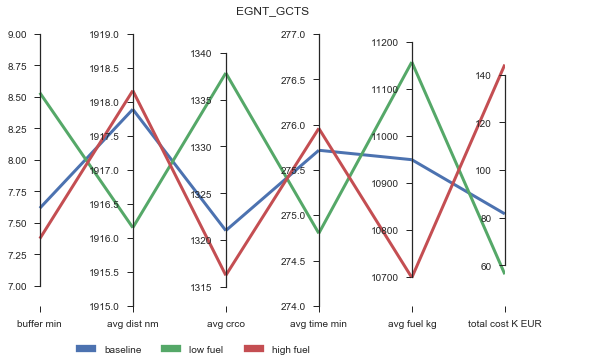

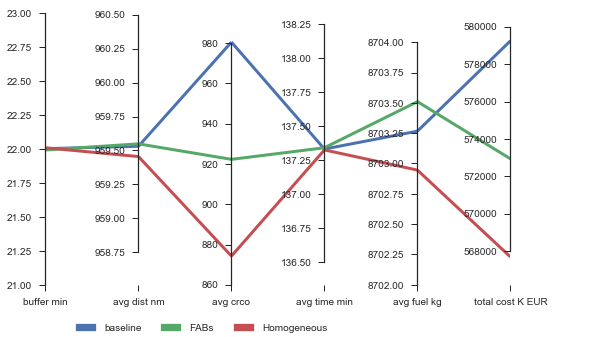

In [4]:
import general_tools3 as gt3
importlib.reload(gt3)
importlib.reload(u)

def dataframe_results(df,case):
    dfresults = pd.DataFrame([{'case':case,
                    'buffer min':df['schedule_buffer_min'].mean(),
                    'avg dist nm': df['fp_distance_nm'].mean(),
                    'total dist nm': df['fp_distance_nm'].sum()/10,
                    'avg crco': df['crco_cost_EUR'].mean(),
                    'total crco K EUR':df['crco_cost_EUR'].sum()/1000/10,
                    'avg time min': df['fp_min'].mean(),
                    'total time K min': df['fp_min'].sum()/1000/10,
                    'avg fuel kg': df['fp_fuel_kg'].mean(),
                    'total cost K EUR':df['crco_cost_EUR'].sum()/1000/10+df['fuel_cost_EUR'].sum()/1000/10}])
    
    return dfresults


df=dataframe_results(fs.loc[(fs['scenario']==0)],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4)],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5)],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg',
                       'total cost K EUR']],'case','')



df=dataframe_results(fs.loc[(fs['scenario']==0) & (fs['num_options']==1)],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4) & (fs['num_options']==1)],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5) & (fs['num_options']==1)],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg',
                       'total cost K EUR']],'case','only 1 option')

df=dataframe_results(fs.loc[(fs['scenario']==0) & (fs['num_options']>1)],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4) & (fs['num_options']>1)],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5) & (fs['num_options']>1)],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg',
                       'total cost K EUR']],'case','more than 1 option')


orig="EGNT"
dest="GCTS"

print(len(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))]))

df=dataframe_results(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg',
                       'total cost K EUR']],'case',orig+"_"+dest)





df=dataframe_results(fs.loc[(fs['scenario']==0)],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==6)],'FABs').append(
             dataframe_results(fs.loc[(fs['scenario']==7)],'Homogeneous')))


u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg',
                       'total cost K EUR']],'case','')



160


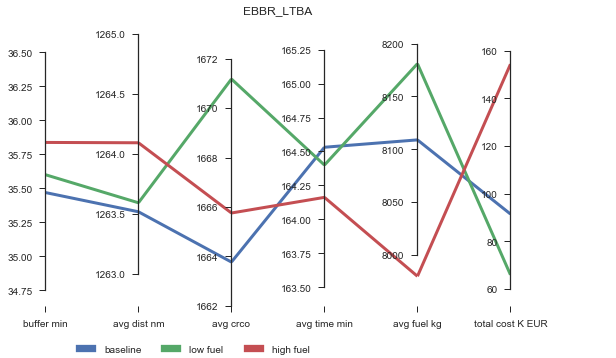

In [5]:

orig="EBBR"
dest="LTBA"

print(len(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))]))

df=dataframe_results(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg',
                       'total cost K EUR']],'case',orig+"_"+dest)


In [ ]:

df=dataframe_results(fs.loc[(fs['scenario']==0)],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4)],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5)],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg',
                       'total cost K EUR']],'case','')



In [ ]:

gt3.bootstrap_mean_test(fs.loc[(fs['scenario']==5) & (fs['icao_orig']=="LTBA")
                               & (fs['icao_dest']=="EGKK") ,'crco_cost_EUR'].tolist(),
                        fs.loc[(fs['scenario']==4) & (fs['icao_orig']=="LTBA")
                               & (fs['icao_dest']=="EGKK"),'crco_cost_EUR'].tolist())



440


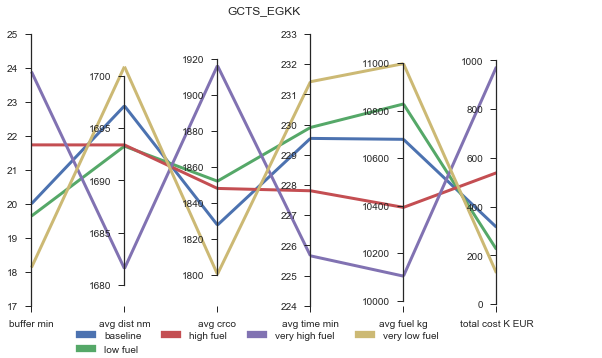

In [7]:
orig="LPPT"
dest="EGLL"

orig=""
dest=""

orig="GCTS"
dest="EGKK"

importlib.reload(u)

print(len(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))]))

df=dataframe_results(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'high fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==28) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'very high fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==29) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'very low fuel')))))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg',
                       'total cost K EUR']],'case',orig+"_"+dest)


In [ ]:
orig="GCTS"
dest="EGKK"

print(len(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))]))

df=dataframe_results(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'high fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==28) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'very high fuel'))))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg',
                       'total cost K EUR']],'case',orig+"_"+dest)


In [ ]:


df=dataframe_results(fs.loc[(fs['scenario']==0)],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4)],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5)],'high fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==28)],'very high fuel'))))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg',
                       'total cost K EUR']],'case','')


In [ ]:
#gt3.bootstrap_mean_test(fs.loc[(fs['scenario']==28) ,'fp_fuel_kg'].tolist(),
#                        fs.loc[(fs['scenario']==4) ,'fp_fuel_kg'].tolist())

gt3.bootstrap_mean_test(fs.loc[(fs['scenario']==28) & (fs['num_options']>1) ,'crco_cost_EUR'].tolist(),
                        fs.loc[(fs['scenario']==4) & (fs['num_options']>1),'crco_cost_EUR'].tolist())


In [ ]:
importlib.reload(u)
intensity=[0.05073502850735363,
0.07887848457848254,
0.21389724909266864,
0.04426497577679454,
0.61222426204470066]

u.order_option(intensity)

In [ ]:
order_values

In [ ]:
np.argsort(order_values)+1

In [ ]:

df=dataframe_results(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==6) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==7) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg',
                       'total cost K EUR']],'case',orig+"_"+dest)

 ## MAPS O-D PAIR AND DEMAND BETWEEN ROUTES

In [8]:
import cartopy.crs as ccrs
icao_orig="EGNT"
icao_dest="GCTS"

d_coords_route_pool = mysql_vista.read_coord_trajectory_route(icao_orig,icao_dest)

unique_id = d_coords_route_pool['id'].drop_duplicates()

min_lon = min(d_coords_route_pool['lon'])
max_lon = max(d_coords_route_pool['lon'])
min_lat = min(d_coords_route_pool['lat'])
max_lat = max(d_coords_route_pool['lat'])

scale = 5

fig=plt.figure(figsize=(2.61538461538*scale, 3*scale))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon-3,max_lon+3,min_lat-3,max_lat+3],
             crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

for i in unique_id:
    ax.plot(d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lon'],
             d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lat'], linewidth=1,
             transform=ccrs.Geodetic()
             )
    
    ax.scatter(d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lon'],
             d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lat'], linewidth=1,
             transform=ccrs.Geodetic()
             )
    
    
    
plt.show()


InterfaceError: (mysql.connector.errors.InterfaceError) 2003: Can't connect to MySQL server on '10.20.198.170:3306' (10060 A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond)

In [ ]:
d_coords_route_pool['id'].drop_duplicates()

In [ ]:
import cartopy.crs as ccrs
importlib.reload(mysql)

mysql_vista = mysql.DataAccessVista(hostname,port,username,password,database_vista)

def plot_usage_routes(icao_orig,icao_dest,scenario_id,title="",max_widht=20):

    d_f_p_route = mysql_vista.read_number_flights_per_route(scenario_id,icao_orig,icao_dest,other_conditions="fps.FPS_run>=61")
    d_f_p_route['per_flights_using']=d_f_p_route['num_flights_per_route']/d_f_p_route['num_flights_per_route'].sum()
    dict_usage = d_f_p_route.set_index('route_pool_id').to_dict()['per_flights_using']

    d_coords_route_pool = mysql_vista.read_coord_trajectory_route(icao_orig,icao_dest)

    unique_id = d_coords_route_pool['id'].drop_duplicates()

    min_lon = min(d_coords_route_pool['lon'])
    max_lon = max(d_coords_route_pool['lon'])
    min_lat = min(d_coords_route_pool['lat'])
    max_lat = max(d_coords_route_pool['lat'])

    scale = 3
    resolution = '50m'
    category = 'cultural'
    name = 'admin_0_countries'
    
    shpfilename = shapereader.natural_earth(resolution, category, name)
    # read the shapefile using geopandas
    df = geopandas.read_file(shpfilename)
    
    # read the European borders
    poly = df.loc[(df['CONTINENT'] == 'Europe') | 
                  ((df['CONTINENT']=="Africa") &
                   (df['SUBREGION']=="Northern Africa") | 
                  ((df['CONTINENT']=="Asia") &
                   (df['SUBREGION']=="Western Asia")))]['geometry']

    

    fig=plt.figure(figsize=(2.61538461538*scale, 3*scale))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([min_lon-3,max_lon+3,min_lat-3,max_lat+3],
                 crs=ccrs.PlateCarree())
    ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', 
                      edgecolor='0.9')
    ax.coastlines(resolution='50m')

    
    
    

    for i in unique_id:
        lw=dict_usage.get(i,0)*20
        
        ax.plot(d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lon'],
                     d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lat']+random.randint(0,10)/20, linewidth=lw,alpha=0.6,
                     transform=ccrs.Geodetic()
                     )
        
        print(i)
        #if i>9228:
        #    break
        


        ax.scatter(d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lon'],
                 d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lat'], linewidth=lw,
                 transform=ccrs.Geodetic()
             )


    plt.title(title)
    plt.show()


icao_orig="EGKK"
icao_dest="GCTS"
icao_orig="LFPG"
icao_dest="LTBA"

icao_orig="EGKK"
icao_dest="GCTS"

icao_orig="EDDB"
icao_dest="LIMC"

icao_orig="LEMD"
icao_dest="EDDB"


icao_orig="EGKK"
icao_dest="GCTS"

icao_orig="LGAV"
icao_dest="LFPG"

max_width=15
plot_usage_routes(icao_orig,icao_dest,0,'baseline',max_width)
plot_usage_routes(icao_orig,icao_dest,4,'low fuel',max_width)
plot_usage_routes(icao_orig,icao_dest,5, 'high fuel',max_width)
plot_usage_routes(icao_orig,icao_dest,28, 'very high fuel',max_width)
plot_usage_routes(icao_orig,icao_dest,29, 'very low fuel',max_width)
plot_usage_routes(icao_orig,icao_dest,6, 'FAB',max_width)
plot_usage_routes(icao_orig,icao_dest,7, 'Homogeneous',max_width)



In [ ]:
importlib.reload(u)
importlib.reload(mysql)
mysql_vista = mysql.DataAccessVista(hostname,port,username,password,database_vista)

scenario_id=29
d_f_p_route = mysql_vista.read_number_flights_per_route(scenario_id,icao_orig,icao_dest,other_conditions="fps.FPS_run>=61")
d_f_p_route['per_flights_using']=20*d_f_p_route['num_flights_per_route']/d_f_p_route['num_flights_per_route'].sum()
dict_usage = d_f_p_route.set_index('route_pool_id').to_dict()['per_flights_using']

d_coords_route_pool = mysql_vista.read_coord_trajectory_route(icao_orig,icao_dest)

u.plot_trajectory_in_map(d_coords_route_pool,title="Test",scale=3, linewidth=1.5, linewidth_dict=dict_usage,
                         plot_markers=True, add_random=True)

In [ ]:
icao_orig="LEMD"
icao_dest="EDDB"
icao_orig="EGKK"
icao_dest="GCTS"
icao_orig="LGAV"
icao_dest="LFPG"
scenario_id=29
d_f_p_route = mysql_vista.read_number_flights_per_route(scenario_id,icao_orig,icao_dest,other_conditions="fps.FPS_run>=61")
d_f_p_route['per_flights_using']=20*d_f_p_route['num_flights_per_route']/d_f_p_route['num_flights_per_route'].sum()

d_f_p_route

In [ ]:
from cartopy.io import shapereader
import numpy as np
import geopandas
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

# get natural earth data (http://www.naturalearthdata.com/)

# get country borders
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shpfilename)

# read the german borders
poly = df.loc[(df['CONTINENT'] == 'Europe') | 
              ((df['CONTINENT']=="Africa") &
               (df['SUBREGION']=="Northern Africa") | 
              ((df['CONTINENT']=="Asia") &
               (df['SUBREGION']=="Western Asia")))]['geometry']#.values[0]


fig=plt.figure(figsize=(20, 15))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', 
                  edgecolor='0.9')

ax.coastlines(resolution='50m')

ax.set_extent([-40, 70, 30, 70], crs=ccrs.PlateCarree())

plt.show()

In [ ]:
df.columns

In [ ]:
df.loc[(df['CONTINENT']=="Europe"),['TYPE']]
df.loc[(df['CONTINENT']=="Asia"),['SUBREGION']].drop_duplicates()


## REVENUE METRICS PER NAS

In [ ]:
def revenues_per_NAS_scenario(scenario_id,scenario_name,other_conditions):
    drev, drev_avg=mysql_vista.read_revenue_per_NAS(scenario_id,other_condition="fps.FPS_run>=61")
    
    drev_avg=drev_avg.T
    drev_avg.columns = drev_avg.iloc[0]
    drev_avg=drev_avg.reindex(drev_avg.index.drop('nas_sid'))
    drev_avg.rename(columns={'index':'scenario'})
    drev_avg['scenario']=scenario_name
    drev_avg.reset_index(inplace=True)


    return drev_avg
    
    
other_condition="fps.FPS_run>=61"
drev = revenues_per_NAS_scenario(0,'baseline',other_condition).append(
       revenues_per_NAS_scenario(4,'low fuel',other_condition).append(
       revenues_per_NAS_scenario(5,'high fuel',other_condition).append(
       revenues_per_NAS_scenario(28,'very high fuel',other_condition).append(
       revenues_per_NAS_scenario(29,'very low fuel',other_condition))))).drop(["index"],axis=1)
           


filter_col = [x for x in drev.columns if (not x.startswith('O')) and (not x.startswith('U')) 
              and (not x.startswith('D')) and (not x.startswith('B')) and (not x.startswith('G'))
              and (not x.startswith('H')) and (len(x)>1) or x=="GC"]

#u.plot_results_radial(d[['scenario','LE','EG','AZ','LF','LP']],case_column="scenario",vmin=0.9)
u.plot_results_radial(drev[filter_col],case_column="scenario",vmin=0.95)

In [ ]:
importlib.reload(u)
u.plot_results_radial(drev[filter_col],case_column="scenario",vmin=0.80)

In [ ]:
drev

## DEMAND IN NAS

In [ ]:
importlib.reload(mysql)
mysql_vista = mysql.DataAccessVista(hostname,port,username,password,database_vista)

d_ansp=mysql_vista.read_airspace_entry_on_selection(0,"fps.FPS_run>=61")

In [ ]:
d_ansp

In [ ]:
demand_0=d_a_0.groupby("nas_sid",as_index=False)['fp_option_id'].count().T
demand_0.columns = demand_0.iloc[0]
demand_0=demand_0.reindex(demand_0.index.drop('nas_sid'))
demand_0.rename(columns={'index':'scenario'})
demand_0['scenario']="baseline"
demand_0.reset_index(inplace=True)

## OTHER - OLD

In [ ]:
import sys
sys.path.insert(1,'../../../../libs')
sys.path.insert(1,'../py')
import importlib

import fp_generator_functions as fgf
importlib.reload(mysql)
importlib.reload(fgf)
importlib.reload(u)

for i in range(0,10):
    print(i)
    fp_o= fgf.flight_plan_option_selection(hostname,port,username,password,database_vista,scenario_id = 6,FPG_run=14)

print("Done")

In [ ]:
fs_old = fs.copy()

In [ ]:
fs = mysql_vista.read_flights_selected(other_condition="fo.FPG_run>=11",only_first_preference=True)

In [ ]:
foptions = mysql_vista.read_number_options_per_schedule()

In [ ]:
foptions.head()

In [ ]:
fs = pd.merge(fs, foptions, on="schedule_id", how="left")

In [ ]:
fs.columns

In [ ]:
fs[['scenario','FPO_run']].drop_duplicates()

In [ ]:
importlib.reload(u)
def dataframe_results(df,case):
    dfresults = pd.DataFrame([{'case':case,
                    'buffer min':df['schedule_buffer_min'].mean(),
                    'avg dist nm': df['fp_distance_nm'].mean(),
                    'total dist nm': df['fp_distance_nm'].sum()/1000000,
                    'avg crco': df['crco_cost_EUR'].mean(),
                    'total crco M EUR':df['crco_cost_EUR'].sum()/1000000,
                    'avg time min': df['fp_min'].mean(),
                    'total time M min': df['fp_min'].sum()/1000000,
                    'avg fuel kg': df['fp_fuel_kg'].mean()}])
    
    return dfresults



df=dataframe_results(fs.loc[(fs['scenario']==0) & (fs['num_options']==1)],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4) & (fs['num_options']==1)],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5) & (fs['num_options']==1)],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg']],'case','only 1 option')

#u.plot_results_radial(df,'case',vmin=0.95)



df=dataframe_results(fs.loc[(fs['scenario']==0) & (fs['num_options']>1)],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4) & (fs['num_options']>1)],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5) & (fs['num_options']>1)],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg']],'case','more that 1 option')

#u.plot_results_radial(df,'case',vmin=0.95)



df=dataframe_results(fs.loc[(fs['scenario']==0) & (fs['num_options']>5)],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4) & (fs['num_options']>5)],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5) & (fs['num_options']>5)],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg']],'case','more than 5 options')


#u.plot_results_radial(df,'case',vmin=0.95)





df=dataframe_results(fs.loc[fs['scenario']==0],'baseline').append(
             dataframe_results(fs.loc[fs['scenario']==4],'low fuel').append(
             dataframe_results(fs.loc[fs['scenario']==5],'high fuel')))

u.plot_results_line(df,'case')


df=dataframe_results(fs.loc[fs['scenario']==0],'baseline').append(
             dataframe_results(fs.loc[fs['scenario']==6],'FABs'))

u.plot_results_line(df,'case')

#u.plot_results_radial(df,'case',vmin=0.95)




#u.plot_results_radial(df,'case',vmin=0.95)



#df = dataframe_results(fp_sched_fnom,'baseline').append(
#             dataframe_results(fp_sched_fcrcohigh,'crco high'))
#u.plot_results_line(df,'case')

print("A")

In [ ]:

orig="EN"
dest="LE"

orig="EGKK"
dest="GCTS"

orig=""
dest=""

orig="EGKK"
dest="GCTS"

'''
df=dataframe_results(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg']],'case',orig+"_"+dest)




df=dataframe_results(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==7) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'homo').append(
             dataframe_results(fs.loc[(fs['scenario']==25) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'homo low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==27) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'homo high fuel'))))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg']],'case',orig+"_"+dest)

'''

orig="E"
dest="G"

df=dataframe_results(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==4) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'low fuel').append(
             dataframe_results(fs.loc[(fs['scenario']==5) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'high fuel')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg']],'case',orig+"_"+dest)

'''

df=dataframe_results(fs.loc[(fs['scenario']==0) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'baseline').append(
             dataframe_results(fs.loc[(fs['scenario']==7) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'homo').append(
             dataframe_results(fs.loc[(fs['scenario']==6) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))],'FAB')))

u.plot_results_line(df[['case','buffer min','avg dist nm','avg crco', 'avg time min', 'avg fuel kg']],'case',orig+"_"+dest)
'''

print("A")

In [ ]:
drev_0, num_runs_0=mysql_vista.read_revenue_per_NAS(scenario_id=0,other_condition="fo.FPG_run>=11")



In [ ]:
drev_4, drev_4_avg=mysql_vista.read_revenue_per_NAS(scenario_id=4,other_condition="fo.FPG_run>=11")

In [ ]:
drev_5, drev_5_avg=mysql_vista.read_revenue_per_NAS(scenario_id=5,other_condition="fo.FPG_run>=11")

In [ ]:
rev_0=drev_0.T
rev_0.columns = rev_0.iloc[0]
rev_0=rev_0.reindex(rev_0.index.drop('nas_sid'))
rev_0.rename(columns={'index':'scenario'})
rev_0['scenario']="baseline"
rev_0.reset_index(inplace=True)

rev_4=drev_4.T
rev_4.columns = rev_4.iloc[0]
rev_4=rev_4.reindex(rev_4.index.drop('nas_sid'))
rev_4.rename(columns={'index':'scenario'})
rev_4['scenario']="low fuel"
rev_4.reset_index(inplace=True)

rev_5=drev_5.T
rev_5.columns = rev_5.iloc[0]
rev_5=rev_5.reindex(rev_5.index.drop('nas_sid'))
rev_5.rename(columns={'index':'scenario'})
rev_5['scenario']="high fuel"
rev_5.reset_index(inplace=True)



In [ ]:
drev_0, num_runs_0=mysql_vista.read_revenue_per_NAS(scenario_id=0,other_condition="fo.FPG_run>=11")
importlib.reload(u)
drev=rev_0.append(rev_4).append(rev_5).drop(["index"],axis=1)
filter_col = [x for x in drev.columns if (not x.startswith('O')) and (not x.startswith('U')) 
              and (not x.startswith('D')) and (not x.startswith('B')) and (not x.startswith('G'))
              and (not x.startswith('H')) and (len(x)>1) or x=="GC"]

#u.plot_results_radial(d[['scenario','LE','EG','AZ','LF','LP']],case_column="scenario",vmin=0.9)
u.plot_results_radial(drev[filter_col],case_column="scenario",vmin=0.95)

In [ ]:
importlib.reload(u)
drev=rev_0.append(rev_4).append(rev_5).drop(["index"],axis=1)
filter_col = [x for x in drev.columns if (not x.startswith('O')) and (not x.startswith('U')) 
              and (not x.startswith('D')) and (not x.startswith('B')) and (not x.startswith('G'))
              and (not x.startswith('H')) and (len(x)>1) or x=="GC"]

#u.plot_results_radial(d[['scenario','LE','EG','AZ','LF','LP']],case_column="scenario",vmin=0.9)
u.plot_results_radial(drev[filter_col],case_column="scenario",vmin=0.95)

In [ ]:
drev_4.head()

In [ ]:
num_runs_0.loc[0].item()

In [ ]:
drev_0_avg = drev_0.copy()
drev_0_avg['crco_kEUR']=drev_0_avg['crco_kEUR'].apply(lambda x: x/num_runs_0.loc[0].item())
drev_0_avg.head()

In [ ]:
t=fs.loc[(fs['scenario']==6) & 
                            (fs['icao_orig'].str.startswith(orig)) &
                            (fs['icao_dest'].str.startswith(dest))]

In [ ]:
doc=[31147.5,
29284.89,
24990.420000000002,
26545.96,
30156.62,
29443.96,
30245.23,
28772.67,
32318.649999999998,
29253.239999999998,
29687.78,
28195.3,
28534.91,
29045.15,
34186.4,
31433.36,
32232.489999999998,
27265.43]
print(doc)
print(np.round(100*u.intensity_function(doc,2000),2))

doc=[14075.699999999999,
12810.96,
12820.32,
14982.23,
14658.82,
14599.31,
14840.75]
print(doc)
print(np.round(100*u.intensity_function(doc,2000),2))


In [ ]:
df

In [ ]:
fs.loc[(fs['scenario']==5) & (fs['num_options']==1)]['schedule_buffer_min'].mean()

In [ ]:
fs.loc[(fs['scenario']==0) & (fs['num_options']==1)]['schedule_buffer_min'].mean()

In [ ]:
fs.loc[(fs['scenario']==4) & (fs['num_options']==1)]['schedule_buffer_min'].mean()

In [ ]:
len(fs.loc[(fs['scenario']==0) & (fs['num_options']==4)]['schedule_buffer_min'])

In [ ]:
len(fs.loc[(fs['scenario']==0) & (fs['num_options']==1)]['schedule_buffer_min'])

In [ ]:
'''
f=plt.figure(figsize=(200,10))


fs.loc[((fs['scenario']==0) & (fs['schedule_buffer_min']>-50)
       & (fs['schedule_buffer_min']<120)),['schedule_buffer_min']].hist(alpha=0.5, bins=100, axes=f.get_axes())#figsize=(20,10))
fs.loc[((fs['scenario']==4) & (fs['schedule_buffer_min']>-50)
       & (fs['schedule_buffer_min']<120)),['schedule_buffer_min']].hist(alpha=0.5, bins=100)
fs.loc[((fs['scenario']==5) & (fs['schedule_buffer_min']>-50)
       & (fs['schedule_buffer_min']<120)),['schedule_buffer_min']].hist(alpha=0.5, bins=100)
'''
#fs.hist(column='schedule_buffer_min', bins=100, by='scenario', sharex=True, sharey=True)
'''
#fs.loc[(fs['scenario']==4,'schedule_buffer_min'].hist(alpha=0.5, bins=100)
#fs.loc[(fs['scenario']==5,'schedule_buffer_min'].hist(alpha=0.5, bins=100)
#plt.figure(figsize=(20,100))
#plt.gcf().clear()

'''
#plt.show()

min_buffer=-30
max_buffer=100

f=plt.figure(figsize=(20,10))


#count, division = np.histogram(fs.loc[((fs['scenario']==0) & (fs['schedule_buffer_min']>min_buffer)
#       & (fs['schedule_buffer_min']<max_buffer)),['schedule_buffer_min']],bins=100)

plt.hist(fs.loc[((fs['scenario']==0) & (fs['schedule_buffer_min']>min_buffer)
       & (fs['schedule_buffer_min']<max_buffer)),'schedule_buffer_min'])

plt.hist(fs.loc[((fs['scenario']==4) & (fs['schedule_buffer_min']>min_buffer)
       & (fs['schedule_buffer_min']<max_buffer)),'schedule_buffer_min'],bins=100,alpha=0.5)


#plt.plot([(a+b)/2 for a, b in zip(division, division[1:])],count/sum(count))

count, division = np.histogram(fs.loc[((fs['scenario']==4) & (fs['schedule_buffer_min']>min_buffer)
       & (fs['schedule_buffer_min']<max_buffer)),['schedule_buffer_min']],bins=100)
#plt.plot([(a+b)/2 for a, b in zip(division, division[1:])],count/sum(count))

count, division = np.histogram(fs.loc[((fs['scenario']==5) & (fs['schedule_buffer_min']>min_buffer)
       & (fs['schedule_buffer_min']<max_buffer)),['schedule_buffer_min']],bins=100)
#plt.plot([(a+b)/2 for a, b in zip(division, division[1:])],count/sum(count))

#plt.legend(['a','b','c'])

plt.show()




In [ ]:
min_buffer=-30
max_buffer=100

A = fs.loc[((fs['scenario']==0) & (fs['schedule_buffer_min']>min_buffer)
       & (fs['schedule_buffer_min']<max_buffer)),'schedule_buffer_min'].tolist()

B = fs.loc[((fs['scenario']==4) & (fs['schedule_buffer_min']>min_buffer)
       & (fs['schedule_buffer_min']<max_buffer)),'schedule_buffer_min'].tolist()

C = fs.loc[((fs['scenario']==5) & (fs['schedule_buffer_min']>min_buffer)
       & (fs['schedule_buffer_min']<max_buffer)),'schedule_buffer_min'].tolist()


fig=plt.figure(figsize=(20,10))
#ax = plt.axes()
#plt.hold(True)

# first boxplot pair
bp = plt.boxplot(A, positions = [1], widths = 0.6)
#plt.setBoxColors(bp)

# second boxplot pair
bp = plt.boxplot(B, positions = [2], widths = 0.6)
#setBoxColors(bp)

# thrid boxplot pair
bp = plt.boxplot(C, positions = [3], widths = 0.6)
#setBoxColors(bp)

'''
# set axes limits and labels
xlim(0,9)
ylim(0,9)
ax.set_xticklabels(['A', 'B', 'C'])
ax.set_xticks([1.5, 4.5, 7.5])

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Apples', 'Oranges'))
hB.set_visible(False)
hR.set_visible(False)

savefig('boxcompare.png')
'''
plt.show()


In [ ]:
count, division = np.histogram(fs['schedule_buffer_min'],bins=100)


In [ ]:

len([(a+b)/2 for a, b in zip(division, division[1:])])

In [ ]:

plt.style.use('seaborn-deep')

x = np.random.normal(1, 2, 5000)
y = np.random.normal(-1, 3, 5000)
data = np.vstack([x, y]).T
bins = np.linspace(-10, 10, 30)

plt.hist(data, bins, alpha=0.7, label=['x', 'y'])
plt.legend(loc='upper right')
plt.show()

In [ ]:
fp_schedules=mysql_vista.read_historical_schedules_with_block_time()

In [ ]:
fp_options=mysql_vista.read_fp_options()#"WHERE fp_generator_run=2")

In [ ]:
fp_options['fp_generator_run'].drop_duplicates()

In [ ]:
fp_options_clean=fp_options[~fp_options['tow'].isnull()]
fp_options_clean.reset_index(drop=True)
print(len(fp_options))
print(len(fp_options_clean))

In [ ]:
fp_options_clean.columns

In [ ]:
def apply_fuel_crco_cost(dfp,fuel_cost,crco=1):
    fp = dfp.copy()
    fp['fuel_cost'] = fp['fp_fuel_kg'] * fuel_cost
    fp['crco_cost'] = fp['crco_cost'] *crco
    fp['doc'] = fp['fuel_cost'] + fp['crco_cost']
    return fp


fp_fnom = apply_fuel_crco_cost(fp_options_clean,0.5)
fp_flow = apply_fuel_crco_cost(fp_options_clean,0.1)
fp_fhigh = apply_fuel_crco_cost(fp_options_clean,1)
fp_fvhigh = apply_fuel_crco_cost(fp_options_clean,2)
fp_crcohigh = apply_fuel_crco_cost(fp_options_clean,0.5,2)



In [ ]:
def intensity_function(cs):
        smoothness_fp=1000
        if len(cs)>1:
            st = np.exp(-(np.array(cs)-min(cs))/smoothness_fp)
            ints = st/st.sum()
        else:
            ints = np.array([1.])
        return ints
    
def choose_option(cs):
    ints=intensity_function(cs)
    sel=ints==np.random.choice(ints,1,p=ints)
    
    return sel

def select_flights(df):
    df['selected'] = df.groupby(['schedule_id','fp_generator_run'])['doc'].transform(choose_option)
    df_selected = df.loc[df['selected']==1]
    return df_selected

fp_sel_fnom = select_flights(fp_fnom)
fp_sel_flow = select_flights(fp_flow)
fp_sel_fhigh = select_flights(fp_fhigh)
fp_sel_fvhigh = select_flights(fp_fvhigh)
fp_sel_fcrcohigh = select_flights(fp_crcohigh)
    
    
#fp_options_clean['prob_selected']=fp_options_clean.groupby(['schedule_id','fp_generator_run'])['doc'].transform(intensity_function)


In [ ]:
len(fp_sel_fnom)

In [ ]:
def add_schedules_compute_buffer(df, ds):
    df = pd.merge(df, ds, left_on="schedule_id", right_on="nid", how="inner", suffixes=("_fp","_s"))
    df['buffer'] = df['block_time']-df['fp_min']
    return df

fp_sched_fnom = add_schedules_compute_buffer(fp_sel_fnom,fp_schedules)
fp_sched_flow = add_schedules_compute_buffer(fp_sel_flow,fp_schedules)
fp_sched_fhigh = add_schedules_compute_buffer(fp_sel_fhigh,fp_schedules)
fp_sched_fvhigh = add_schedules_compute_buffer(fp_sel_fvhigh,fp_schedules)
fp_sched_fcrcohigh = add_schedules_compute_buffer(fp_sel_fcrcohigh,fp_schedules)


In [ ]:
df=pd.merge(pd.merge(pd.merge(fp_sched_fnom.groupby('fp_generator_run', as_index=False)['buffer'].mean(),
fp_sched_fnom.groupby('fp_generator_run', as_index=False)['fp_distance_nm'].mean(), on="fp_generator_run"),
fp_sched_fnom.groupby('fp_generator_run', as_index=False)['crco_cost'].mean(), on="fp_generator_run"),
(fp_sched_fnom.groupby('fp_generator_run', as_index=False)['crco_cost'].sum()).rename(columns={'crco_cost': 'total crco M EUR'}),
on="fp_generator_run")
df['total crco M EUR']=df['total crco M EUR']/1000000

u.plot_results_line(df,'fp_generator_run')

In [ ]:
importlib.reload(u)

def dataframe_results(df,case):
    dfresults = pd.DataFrame([{'case':case,'buffer':df['buffer'].mean(),
                    'avg dist nm': df['fp_distance_nm'].mean(),
                    'total dist nm': df['fp_distance_nm'].sum()/1000000,
                    'avg crco': df['crco_cost'].mean(),
                    'total crco M EUR':df['crco_cost'].sum()/1000000,
                    'avg time min': df['fp_min'].mean(),
                    'total time M min': df['fp_min'].sum()/1000000,
                    'avg fuel kg': df['fp_fuel_kg'].mean()}])
    
    return dfresults

fp_sched_fnom = add_schedules_compute_buffer(fp_sel_fnom,fp_schedules)
fp_sched_flow = add_schedules_compute_buffer(fp_sel_flow,fp_schedules)
fp_sched_fhigh = add_schedules_compute_buffer(fp_sel_fhigh,fp_schedules)
fp_sched_fvhigh = add_schedules_compute_buffer(fp_sel_fvhigh,fp_schedules)
fp_sched_fcrcohigh = add_schedules_compute_buffer(fp_sel_fcrcohigh,fp_schedules)


df=dataframe_results(fp_sched_fnom,'baseline').append(
             dataframe_results(fp_sched_flow,'low fuel').append(
             dataframe_results(fp_sched_fhigh,'high fuel').append(
             dataframe_results(fp_sched_fvhigh,'very high fuel'))))

u.plot_results_line(df,'case')

u.plot_results_radial(df,'case',vmin=0.9)


df = dataframe_results(fp_sched_fnom,'baseline').append(
             dataframe_results(fp_sched_fcrcohigh,'crco high'))
u.plot_results_line(df,'case')

In [ ]:
df

In [ ]:
importlib.reload(u)

u.plot_results_radial(df,'case')

df

In [ ]:
fp_opt_sel_schedule['buffer'].mean()

In [ ]:
df.head()

In [ ]:
df = pd.DataFrame([{'case':'scenario 1','buffer':22.5,'crco':1367,'distance':3526,'other':34},
                   {'case':'scenario 2','buffer':26.6,'crco':1561,'distance':1363,'other':63}])

In [ ]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See  doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data



N = 9
theta = radar_factory(N, frame='polygon')

data = example_data()
spoke_labels = data.pop(0)

fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axes.flatten(), data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
ax = axes[0, 0]
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
legend = ax.legend(labels, loc=(0.9, .95),
                   labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()

In [ ]:
df

In [ ]:
df2 = df.drop('case',axis=1).copy()


In [ ]:
df2['buffer']=df2['buffer']/df2['buffer'].max()
df2['avg crco']=df2['avg crco']/df2['avg crco'].max()
df2['avg dist nm']=df2['avg dist nm']/df2['avg dist nm'].max()
df2['avg fuel kg']=df2['avg fuel kg']/df2['avg fuel kg'].max()
df2['avg time min']=df2['avg time min']/df2['avg time min'].max()
df2['total dist nm']=df2['total dist nm']/df2['total dist nm'].max()
df2['total crco M EUR']=df2['total crco M EUR']/df2['total crco M EUR'].max()
df2['total time M min']=df2['total time M min']/df2['total time M min'].max()

df2

In [ ]:
(df2-0.2)/(1-0.2)

In [ ]:
#theta[-1]%(2*np.pi)
theta

In [ ]:
vmin=0.2

def 
df3 = (df2-vmin)/(1-vmin)
df3 = df3.drop('total dist nm', axis=1)
N = len(df3.columns)
theta = radar_factory(N, frame='circle')
spoke_labels=df3.columns.tolist()

fig, axes = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)


for i in range(len(df3)):
    axes.plot(theta,df3.iloc[i,:].tolist())
    axes.fill(theta,df3.iloc[i,:], alpha=0.25)


axes.set_rgrids([0, 0.2, 0.4, 0.6, 0.8, 1])
axes.set_yticklabels(np.round(np.append(np.arange(vmin,1,(1-vmin)/5),[1]),2))
axes.set_xticks(theta)

print(spoke_labels)
print(theta)
axes.set_thetalim(-np.pi,np.pi)
axes.set_xticklabels(spoke_labels)

labels = ('Factor 1', 'Factor 2')
legend = axes.legend(labels, loc=(0.9, .95),
                   labelspacing=0.1, fontsize='small')


plt.show()




'''
, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axes.flatten(), data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
ax = axes[0, 0]
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
legend = ax.legend(labels, loc=(0.9, .95),
                   labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()

'''

In [ ]:
data

In [ ]:
fp_opt_sel_schedule.columns

In [ ]:
fp_options = fp_options.loc[:,~fp_options.columns.duplicated()]

In [ ]:
fp_opt_schedule.groupby('fp_generator_run')['buffer'].mean()

In [ ]:
fp_opt_min_doc=fp_opt_schedule.loc[fp_opt_schedule.groupby(['nid','fp_generator_run'])['doc'].idxmin()]


In [ ]:
fp_opt_min_doc.groupby('fp_generator_run')['crco_cost'].sum()

In [ ]:

    
print(intensity_function([3,5,21,412]))
print(intensity_function([3,5,21,412]))
print(intensity_function([3,5,21,412]))
print(intensity_function([3,5,21,412]))
print(intensity_function([30,50,210,4120]))



In [ ]:
fp_opt_schedule

In [ ]:
ints = [ 0.27438777,  0.27383955,  0.26949298,  0.1822797 ]
ints==np.random.choice(
  ints,
  1,
  p=ints
)

In [ ]:
fp_opt_schedule.head()

In [ ]:
#u.get_run_number(model='route_generator',engine=mysql_vista.engine)

mysql_vista.insert_run_version(1,'fp_generator',0.1)

In [ ]:
pd.DataFrame([{'run':3, 'model':'pre'}])

In [ ]:
strategic_run=1
route_generator_run=3
compute_if_not_exists_routes=False
mysql_vista.read_nas_route_pool(scenario_id,strategic_run,route_generator_run)


In [ ]:
s.background_factors

In [ ]:
def order_option(cs):
    ints=u.intensity_function(cs)
    print(ints)
    order = np.random.choice(list(range(1,len(ints)+1)),len(ints),p=ints,replace=False)
    return order
    
def select_flights(df):
    df['selected'] = df.groupby(['schedule_id','fp_generator_run'])['doc'].transform(choose_option)
    df_selected = df.loc[df['selected']==1]
    return df_selected

choose_option([1323,212,19321])

In [ ]:
fp_o.loc[0:10]

In [ ]:

d_nas_crco.loc[d_nas_crco['nas_sid']!="EX",'d_t']=(d_nas_crco.loc[d_nas_crco['nas_sid']!="EX",'d']*\
                                                d_nas_crco.loc[d_nas_crco['nas_sid']!="EX",'t'])/100
d_nas_crco.loc[d_nas_crco['nas_sid']=="EX",'d_t']=(d_nas_crco.loc[d_nas_crco['nas_sid']=="EX",'t']/100)


In [ ]:
crco_d_t=d_nas_crco.loc[d_nas_crco['nas_sid'] !="EX", ['fp_pool_id', 'd_t']].groupby('fp_pool_id', as_index=False).sum()
crco_d_t=pd.merge(crco_d_t,d_nas_crco.loc[d_nas_crco['nas_sid']=="EX",['fp_pool_id','d_t']].rename(columns={'d_t': 'extra'}).groupby('fp_pool_id', as_index=False).min(), 
         on="fp_pool_id", how="left")

crco_d_t.loc[crco_d_t['extra'].isnull(),'extra']=0
crco_d_t.head()

In [ ]:
d_nas_crco.head()

In [ ]:
d_nas_crco.loc[d_nas_crco['t']==0,'nas_sid'].drop_duplicates().to_csv('./nocrco.csv')

In [ ]:
crco_d_t=pd.merge(crco_d_t,d_nas_crco.loc[d_nas_crco['nas_sid']=="EK",['fp_pool_id','d_t']].rename(columns={'d_t': 'extra'}), 
         on="fp_pool_id", how="left")

#crco_d_t.loc[crco_d_t['extra'].isnull(),'extra']=0
crco_d_t.head()

In [ ]:

d_crco['sid']
d_crco.to_sql('crco_charges',mysql_vista.engine,index=False,if_exists="replace")

In [ ]:
d_crco.loc[d_crco['name']=="Spain Canarias"]['sid']

In [ ]:

d_s_fp.loc[d_s_fp['ac_model']=="ATR72-200",['avg_fl','ac_eq','ac_icao','bada_perf']]
max(d_s_fp.loc[d_s_fp['ac_model']=="ATR72-200",'avg_fl'])


In [ ]:
d_s_fp[['cruise_nom_kt','cruise_nom_m']]

len(d_s_fp.columns)
len(d_s_fp)
d_s_fp.loc[d_s_fp['cruise_nom_m']==max(d_s_fp['cruise_nom_m']),'ac_eq']

max(d_s_fp['cruise_nom_m'])


In [ ]:
d_s_fp[['cruise_nom_kt','cruise_nom_m']]

In [ ]:
round(2.524,0)

In [ ]:
estimate_cruise_weights(x['climb_fuel_kg'],x['descent_fuel_kg'],x['cruise_nom_m'],x['cruise_nm'],x['cruise_min'],x['avg_fl'], x['bada_perf'])

In [ ]:
d_s_fp.ix[2832, ['climb_fuel_kg', 'descent_fuel_kg', 'cruise_nom_m','cruise_nm','cruise_min','avg_fl','bada_perf',
                'cruise_speed_request']]

In [ ]:
d_s_fp.ix[2832,'bada_perf'].ac_icao

In [ ]:
uc.kt2m(estimate_cruise_speed(365, d_s_fp.ix[2832,'cruise_speed_request']),365)



In [ ]:
d_s_fp[['id','option_number','ac_icao','ac_eq','bada_code_ac_model','bada_version','fp_distance_nm','climb_nm','descent_nm','cruise_nm',
                                         'avg_fl','fp_min','climb_min','descent_min','cruise_min','cruise_nom_m','cruise_nom_kt','cruise_avg_wind_kt','cruise_ground_kt','climb_fuel_kg','descent_fuel_kg','avg_fl','cruise_nom_m']].to_csv('./t.csv')

In [ ]:

min_crco_cost=120
max_crco_cost=250
    
d_s_fp['crco_cost'] = np.round((np.random.random(size=len(d_s_fp))*
                                       (max_crco_cost-min_crco_cost)+min_crco_cost),2)



d_s_fp['cruise_avg_weight_kg'] = d_s_fp['ac_perf'].apply(lambda x: x.wref if type(x)!=float else 67000)


#Estimate climb/descent and cruise fuel
d_s_fp['cruise_fuel_kg'] = d_s_fp.apply(lambda x: estimate_cruise_fuel(x['avg_fl'],x['cruise_nom_m'],
                                                                x['cruise_avg_weight_kg'],x['cruise_min'],
                                                                x['ac_perf']), axis=1)


#Estimate total time and fuel

d_s_fp['total_fuel_kg']=d_s_fp['climb_fuel_kg']+d_s_fp['cruise_fuel_kg']+d_s_fp['descent_fuel_kg']
  
    
    
    
d_s_fp[['icao_model','ac_eq','ac_implementing','fp_distance_nm','climb_nm','climb_min',
                                         'avg_fl','cruise_avg_weight_kg','cruise_nom_kt','cruise_nom_m',
                                         'cruise_avg_wind_kt','cruise_ground_kt',
                                         'cruise_nm','cruise_min',
                                         'descent_nm','descent_min',
                                         'climb_fuel_kg','descent_fuel_kg','cruise_fuel_kg',
                                        'total_min','total_fuel_kg']].head()

In [ ]:

d_s_fp['ac_eq_dist_type'] = d_s_fp['ac_eq'] + "_" + d_s_fp['f_dist_type']


In [ ]:
dict_climb_iedf

In [ ]:
d_s_fp['iedf_climb']=d_s_fp['ac_eq_dist_type'].apply(lambda x: dict_climb_iedf.get(x).get('iedf') 
                                                     if dict_climb_iedf.get(x,None) != None
                                                     else None)

d_s_fp['iedf_descent']=d_s_fp['ac_eq_dist_type'].apply(lambda x: dict_descent_iedf.get(x).get('iedf') 
                                                     if dict_descent_iedf.get(x,None) != None
                                                     else None)

d_s_fp['iedf_fl']=d_s_fp['ac_eq_dist_type'].apply(lambda x: dict_fl_iedf.get(x).get('iedf') 
                                                     if dict_fl_iedf.get(x,None) != None
                                                     else None)



d_s_fp['iedf_wind']=d_s_fp['co_cd'].apply(lambda x: dict_w_iedf.get(x).get('iedf')
                                                    if dict_w_iedf.get(x,None) != None
                                                    else None)
                         
                                          
d_s_fp['ac_perf']=d_s_fp['ac_implementing'].apply(lambda x: dict_ac_perf_bada4.get(x,None))




In [ ]:
d_s_fp_all_with_dict = d_s_fp.copy()

In [ ]:
d_s_fp=d_s_fp_all_with_dict.copy()

In [ ]:
d_s_fp=d_s_fp_all_with_dict.copy()
d_s_fp=d_s_fp.loc[d_s_fp['ac_eq']=="A340"].copy()
len(d_s_fp)

In [ ]:
d_s_fp[['orig_dest','ac_implementing','fp_distance_nm','climb_nm','climb_min',
                                         'avg_fl','cruise_avg_weight_kg','cruise_nom_kt','cruise_nom_m',
                                         'cruise_avg_wind_kt','cruise_ground_kt',
                                         'cruise_nm','cruise_min',
                                         'descent_nm','descent_min',
                                         'climb_fuel_kg','descent_fuel_kg','cruise_fuel_kg',
                                        'total_min','total_fuel_kg']]

In [ ]:
d_s_fp.head()

In [ ]:
#d_ac_perf_bada4.get(dict_ac_eq_perf.get("A340"))
dict_ac_eq_perf.get("A346")

dict_descent_iedf.get("A340_extra_long")
dict_ac_eq_perf.get("A346")
dict_fl_iedf.keys()
dict_fl_iedf.get("AT42_long")

In [ ]:
d_s_fp['f_dist_type'].cat.categories[d_s_fp['f_dist_type'].cat.codes].tolist()

In [ ]:
d_s_fp['ac_eq']=d_s_fp['icao_model'].apply(lambda x: dict_ac_eq_perf.get(x,'-'))
d_s_fp['ac_implementing']=d_s_fp['icao_model'].apply(lambda x: dict_ac_implementing.get(x,'-'))
d_s_fp['f_dist_type']=d_s_fp['f_dist_type'].cat.categories[d_s_fp['f_dist_type'].cat.codes].tolist()

#if type(d_s_fp.loc[0,'f_dist_type'])==str:
d_s_fp['p_key'] = d_s_fp['ac_eq'] + "_" + d_s_fp['f_dist_type']
#else: 
#    d_s_fp['p_key'] = d_s_fp['ac_eq'] + "_"\
#                           +d_s_fp['f_dist_type'].cat.categories[d_s_fp['f_dist_type'].cat.codes].tolist()
    
d_s_fp = pd.merge(d_s_fp, d_climb_iedf[['p_key','iedf_climb']], on='p_key', how='inner');
d_s_fp = pd.merge(d_s_fp, d_descent_iedf[['p_key','iedf_descent']], on='p_key', how='inner');
d_s_fp = pd.merge(d_s_fp, d_fl_iedf[['p_key','iedf_fl']], on='p_key', how='inner');

d_s_fp = pd.merge(d_s_fp, d_climb_time_lineal[['ac_eq','coef_climb', 'sd_error_climb']], on='ac_eq', how='inner')

d_s_fp = pd.merge(d_s_fp, d_descent_time_lineal[['ac_eq','coef_descent', 'sd_error_descent']], on='ac_eq', how='inner')

d_s_fp['cruise_speed_request']=d_s_fp['ac_eq'].apply(lambda x: d_speed_request.get(x,None))

d_s_fp['ac_perf']=d_s_fp['ac_implementing'].apply(lambda x: d_ac_perf_bada4.get(x,None)) #icao_model
d_s_fp['wind_iedf']=d_s_fp['co_cd'].apply(lambda x: dict_w_iedf.get(x,None))




In [ ]:
#d_fl_iedf[['p_key','iedf_fl']].head()
d_s_fp.head()

In [ ]:
#type(d_s_fp.loc[0,'f_dist_type'])
d_s_fp[['icao_model','ac_eq','ac_implementing','ac_perf']].head()
'iedf_fl' in d_s_fp.columns



In [ ]:
d_s_fp_all=d_s_fp.copy()

In [ ]:
d_s_fp=d_s_fp_all.copy()

In [ ]:

d_s_fp=d_s_fp_all.copy()
d_s_fp=d_s_fp.loc[d_s_fp['ac_eq']=="E145"].copy()
len(d_s_fp)

In [ ]:
import math


def random_time(dist,coef,sd_error):
    time = round(np.random.normal(u.f_fit(dist,*coef),sd_error))
    while time<0:
        time = round(np.random.normal(u.f_fit(dist,*coef),sd_error))
        
    return time

def estimate_climb_fuel(climb_min,avg_fl,ac_perf):
    if type(ac_perf)==float:
        min_fuel=300
        max_fuel=2000
        climb_f = np.round(np.random.random()*(max_fuel-min_fuel)+min_fuel)
        
    else:
        climb_f = np.round(climb_min * ac_perf.estimate_climb_fuel_flow(0,avg_fl))
        
    return climb_f

def estimate_descent_fuel(desc_min,avg_fl,ac_perf):
    if type(ac_perf)==float:
        min_fuel=300
        max_fuel=2000
        descent_f = np.round(np.random.random()*(max_fuel-min_fuel)+min_fuel)
        
    else:
        descent_f = np.round(desc_min * ac_perf.estimate_descent_fuel_flow(avg_fl,0))
        
    return descent_f
        
    
def estimate_cruise_fuel(avg_fl, m, c_avg_weight, c_min, ac_perf):
    if type(ac_perf)==float:
        min_fuel=900
        max_fuel=1500
        cruise_f = np.round(np.random.random()*(max_fuel-min_fuel)+min_fuel)
        
    else:
        
        ff = ac_perf.compute_fuel_flow(avg_fl,c_avg_weight,m)
        
        cruise_f = np.round(ff * c_min)
        
    return cruise_f
    
    
def check_cruise_speed(avg_fl,weight,m):
    return ac_perf.is_mach_in_envelope(avg_fl,weight,m)

def estimate_cruise_speed(avg_fl, iedf_speed_request):
    if type(iedf_speed_request)==float:
        cruise_speed_kt = 10
    else:
        flv=np.array(list(iedf_speed_request.keys()))
        i=abs(flv-avg_fl).argmin()
        if (flv[i]-avg_fl)<0:
            i_next = min(len(flv)-1,i+1)
        else:
            i_next = i

        iedf_i = iedf_speed_request.get(flv[i])
        iedf_i_next = iedf_speed_request.get(flv[i_next])

        randomg=random.uniform(max(min(iedf_i.x),min(iedf_i_next.x)),1)  

        cs_kt_i=iedf_i(randomg)
        cs_kt_i_next=iedf_i_next(randomg)

        cruise_speed_kt = u.proportional(cs_kt_i,cs_kt_i_next,flv[i],flv[i_next],avg_fl)
        
    return cruise_speed_kt
    
    
    

min_crco_cost=120
max_crco_cost=250
    
d_s_fp['crco_cost'] = np.round((np.random.random(size=len(d_s_fp))*
                                       (max_crco_cost-min_crco_cost)+min_crco_cost),2)



d_s_fp['avg_fl']=d_s_fp['iedf_fl'].apply(lambda iedf_f: int(10 * round(2*iedf_f(random.uniform(min(iedf_f.x),1))/10) /2))


#Compute climb/descent/cruise distances
d_s_fp['climb_nm']=d_s_fp['iedf_climb'].apply(lambda iedf_c: np.round(iedf_c(random.uniform(min(iedf_c.x),1)),1))
d_s_fp['descent_nm']=d_s_fp['iedf_descent'].apply(lambda iedf_d: np.round(iedf_d(random.uniform(min(iedf_d.x),1)),1))
d_s_fp['cruise_nm']=d_s_fp['fp_distance_nm']-d_s_fp['climb_nm']-d_s_fp['descent_nm']

#If cruise negative, climb and descent are too long
i_c_neg = d_s_fp['cruise_nm']<0

#Reduce climb and descent as half of the extra cruise we have computed
d_s_fp.loc[i_c_neg, 'descent_nm']=d_s_fp.loc[i_c_neg, 'descent_nm']\
            -np.round(-d_s_fp.loc[i_c_neg, 'cruise_nm']/2)

d_s_fp.loc[i_c_neg, 'climb_nm']=d_s_fp.loc[i_c_neg, 'fp_distance_nm']-d_s_fp.loc[i_c_neg, 'descent_nm']

d_s_fp.loc[i_c_neg, 'cruise_nm']=0

#If the climb or the descent are now negative, we have removed too much climb/descent
#then divide the fligth distance between climb and descent evenly
i_climb_desc_neg=(d_s_fp['climb_nm']<0) | (d_s_fp['descent_nm']<0)
d_s_fp.loc[i_climb_desc_neg, 'climb_nm']=np.ceil(d_s_fp.loc[i_climb_desc_neg, 'fp_distance_nm']/2)
d_s_fp.loc[i_climb_desc_neg, 'descent_nm']=d_s_fp.loc[i_climb_desc_neg, 'fp_distance_nm']\
                                                -d_s_fp.loc[i_climb_desc_neg, 'climb_nm']

    
#Compute climb and descent times based on the lineal distributions of time, 
#with a random considering the sd error of the lineal fitting of time as a
#function of climb/descent distance  
d_s_fp['climb_min'] = d_s_fp.apply(lambda x:random_time(x['climb_nm'],x['coef_climb'],x['sd_error_climb']),axis=1)
d_s_fp['descent_min'] = d_s_fp.apply(lambda x: random_time(x['descent_nm'],x['coef_descent'],x['sd_error_descent']),axis=1)



#Estimate cruise speed/wind and cruise weight
d_s_fp['cruise_nom_kt'] = d_s_fp.apply(lambda x: estimate_cruise_speed(x['avg_fl'], x['cruise_speed_request']),axis=1)
d_s_fp['cruise_nom_m'] = d_s_fp.apply(lambda x: uc.kt2m(x['cruise_nom_kt'],x['avg_fl']), axis=1)

d_s_fp['cruise_nom_kt'] = d_s_fp['cruise_nom_kt'].astype(np.double).round(2)


#min_wind=-50
#max_wind=50

#d_s_fp['cruise_avg_wind_kt'] = np.round((np.random.random(size=len(d_s_fp))*
#                                       (max_wind-min_wind)+min_wind),2)

d_s_fp['cruise_avg_wind_kt'] = d_s_fp['wind_iedf'].apply(lambda x: 
                                                         x.get('iedf')(random.uniform(max(min(x.get('iedf').x),0.2),0.8)))

d_s_fp['cruise_ground_kt']=d_s_fp['cruise_avg_wind_kt']+d_s_fp['cruise_nom_kt']

d_s_fp['cruise_min']=(60*d_s_fp['cruise_nm']/d_s_fp['cruise_ground_kt']) #I need to round this

d_s_fp['cruise_avg_weight_kg'] = d_s_fp['ac_perf'].apply(lambda x: x.wref if type(x)!=float else 67000)




#Estimate climb/descent and cruise fuel
d_s_fp['cruise_fuel_kg'] = d_s_fp.apply(lambda x: estimate_cruise_fuel(x['avg_fl'],x['cruise_nom_m'],
                                                                x['cruise_avg_weight_kg'],x['cruise_min'],
                                                                x['ac_perf']), axis=1)

d_s_fp['climb_fuel_kg'] = d_s_fp.apply(lambda x: estimate_climb_fuel(x['climb_min'],x['avg_fl'],x['ac_perf']), axis=1)
d_s_fp['descent_fuel_kg'] = d_s_fp.apply(lambda x: estimate_climb_fuel(x['descent_min'],x['avg_fl'],x['ac_perf']), axis=1)


#Estimate total time and fuel
d_s_fp['total_min']=d_s_fp['climb_min']+d_s_fp['cruise_min']+d_s_fp['descent_min']
d_s_fp['total_fuel_kg']=d_s_fp['climb_fuel_kg']+d_s_fp['cruise_fuel_kg']+d_s_fp['descent_fuel_kg']
  
    
    
    
    
    
d_s_fp[['icao_model','ac_eq','ac_implementing','fp_distance_nm','climb_nm','climb_min',
                                         'avg_fl','cruise_avg_weight_kg','cruise_nom_kt','cruise_nom_m',
                                         'cruise_avg_wind_kt','cruise_ground_kt',
                                         'cruise_nm','cruise_min',
                                         'descent_nm','descent_min',
                                         'climb_fuel_kg','descent_fuel_kg','cruise_fuel_kg',
                                        'total_min','total_fuel_kg']].head()

In [ ]:
d_s_fp.head()

In [ ]:
mysql_vista.add_possible_flights(d_s_fp)

In [ ]:
d_s_fp_all['ac_type_eq'].unique()

In [ ]:
#_s_fp.loc[d_s_fp['icao_model']=='DH8B'].head()
d_s_fp.loc[50117,:]

In [ ]:
mysql_vista.add_possible_flights(d_s_fp)

In [ ]:
#OLDER STUFF FROM HERE DOWN

In [ ]:
d_s_fp[['id','fpool_id', 'climb_nm','climb_min','cruise_nm','cruise_min','descent_nm','descent_min','total_min',
        'avg_fl','cruise_nominal_kt','cruise_avg_wind_kt','cruise_avg_weight_kg','crco_cost', 'fuel_usage_kg']].rename(
    columns = {'id':'schedule_id'})

In [ ]:
import random

def f_fit(x,a,b):
    return a + b*x

def random_time(dist,ldist):
    time = round(np.random.normal(f_fit(dist,*ldist.get('coef')),ldist.get('sd_error')))
    while time<0:
        time = round(np.random.normal(f_fit(dist,*ldist.get('coef')),ldist.get('sd_error')))
        
    return time



def estimate_performances(d_estimated,
                          dict_climb_iedf,dict_descent_iedf,dict_fl_iedf,
                          descent_time_lineal_dict,climb_time_lineal_dict):
    
    min_fuel=900
    max_fuel=1500
    
    
    
    d_estimated['p_key'] = d_estimated['ac_type_eq'] + "_"\
                           +d_estimated['f_dist_type'].cat.categories[d_estimated['f_dist_type'].cat.codes].tolist()
    
    d_estimated['iedf_climb'] = d_estimated['p_key'].apply(lambda x: dict_climb_iedf.get(x).get('iedf') 
                                                         if not pd.isnull(dict_climb_iedf.get(x))
                                                         else np.nan) 
    
    d_estimated['iedf_descent'] = d_estimated['p_key'].apply(lambda x: dict_descent_iedf.get(x).get('iedf')
                                                           if not pd.isnull(dict_descent_iedf.get(x))
                                                           else np.nan)
    d_estimated['iedf_fl'] = d_estimated['p_key'].apply(lambda x: dict_fl_iedf.get(x).get('iedf')
                                                     if not pd.isnull(dict_fl_iedf.get(x))
                                                      else np.nan)
    
    d_estimated['descent_lineal'] = d_estimated['ac_type_eq'].apply(lambda x: descent_time_lineal_dict.get(x))
    d_estimated['climb_lineal'] = d_estimated['ac_type_eq'].apply(lambda x: climb_time_lineal_dict.get(x))
    

    indexes_ok = ~(pd.isnull(d_estimated['iedf_climb']) | pd.isnull(d_estimated['iedf_descent']) | pd.isnull(d_estimated['iedf_fl']) 
                   | pd.isnull(d_estimated['descent_lineal']) | pd.isnull(d_estimated['climb_lineal']))

    d_estimated['climb_nm']=-1
    d_estimated['descent_nm']=-1
    d_estimated['avg_fl']=-1
    d_estimated['climb_min']=-1
    d_estimated['descent_min']=-1
    d_estimated['climb_descent_nm']=-1
    d_estimated['cruise_nm']=-1
    d_estimated['rmv_climb_desc_nm']=0
    
    
    d_estimated.loc[indexes_ok,'climb_nm']=d_estimated.loc[indexes_ok,'iedf_climb']\
                                             .apply(lambda iedf_c: np.round(iedf_c(random.uniform(min(iedf_c.x),1)),1))
    
    
    d_estimated.loc[indexes_ok,'descent_nm']=d_estimated.loc[indexes_ok,'iedf_descent']\
                                             .apply(lambda iedf_d: np.round(iedf_d(random.uniform(min(iedf_d.x),1)),1))
        
        
    
    d_estimated.loc[indexes_ok,'avg_fl']=d_estimated.loc[indexes_ok,'iedf_fl']\
                                             .apply(lambda iedf_f: np.round(iedf_f(random.uniform(min(iedf_f.x),1))))
    
    
    d_estimated.loc[indexes_ok,'climb_descent_nm']=d_estimated.loc[indexes_ok,'climb_nm']\
                                                   +d_estimated.loc[indexes_ok,'descent_nm']
        
    
    d_estimated.loc[indexes_ok, 'cruise_nm']=d_estimated.loc[indexes_ok,'fp_distance_nm']\
                                             -d_estimated.loc[indexes_ok,'climb_descent_nm']
        
           
    if (d_estimated['cruise_nm']<0).any():
            
        d_estimated.loc[(d_estimated['cruise_nm']<0), 'rmv_climb_desc_nm']=-d_estimated.loc[(d_estimated['cruise_nm']<0), 'cruise_nm']
                    
        d_estimated.loc[(d_estimated['cruise_nm']<0), 'descent_nm']=\
            d_estimated.loc[(d_estimated['cruise_nm']<0), 'descent_nm']\
            -np.round(d_estimated.loc[(d_estimated['cruise_nm']<0), 'rmv_climb_desc_nm']/2)

        d_estimated.loc[(d_estimated['cruise_nm']<0), 'climb_nm']=\
            d_estimated.loc[(d_estimated['cruise_nm']<0), 'fp_distance_nm']\
            -d_estimated.loc[(d_estimated['cruise_nm']<0), 'descent_nm']


        i_climb_desc_neg=(d_estimated['climb_nm']<0) | (d_estimated['descent_nm']<0)
        d_estimated.loc[i_climb_desc_neg, 'climb_nm']=np.ceil(d_estimated.loc[i_climb_desc_neg, 'fp_distance_nm']/2)
        d_estimated.loc[i_climb_desc_neg, 'descent_nm']=d_estimated.loc[i_climb_desc_neg, 'fp_distance_nm']\
                                                        -d_estimated.loc[i_climb_desc_neg, 'climb_nm']


    d_estimated.loc[indexes_ok,'climb_descent_nm']=d_estimated.loc[indexes_ok,'climb_nm']\
                                                   +d_estimated.loc[indexes_ok,'descent_nm']

    d_estimated.loc[indexes_ok, 'cruise_nm']=d_estimated.loc[indexes_ok,'fp_distance_nm']\
                                             -d_estimated.loc[indexes_ok,'climb_descent_nm']


    d_estimated.loc[indexes_ok,'climb_min']=d_estimated.loc[indexes_ok].apply(lambda x: 
                                                                              random_time(x['climb_nm'],x['climb_lineal']),axis=1);
                                                                                            
    
    
    d_estimated.loc[indexes_ok,'descent_min']=d_estimated.loc[indexes_ok].apply(lambda x: 
                                                                                random_time(x['descent_nm'],x['descent_lineal']),axis=1);
                                                                                            
    
    
    
    d_estimated['fuel_usage_kg']=np.random.random()*(max_fuel-min_fuel)+min_fuel
    d_estimated['cruise_nominal_kt']=480
    d_estimated['cruise_avg_weight_kg']=186000
    d_estimated['cruise_avg_wind_kt']=43
    
    d_estimated['cruise_ground_kt']=d_estimated['cruise_avg_wind_kt']+d_estimated['cruise_nominal_kt']

    d_estimated['cruise_min']=round(60*d_estimated['cruise_nm']/d_estimated['cruise_ground_kt'])
    
    d_estimated['total_min']=d_estimated['climb_min']+d_estimated['cruise_min']+d_estimated['descent_min']
    
     
    return d_estimated, indexes_ok


def create_flight_plans(d_schedules, run_id):
    #flight_plan_table=ddb.create_flight_plan_table(dynamodb)
    min_crco_cost=120
    max_crco_cost=250
    fuel_price=0.86


    d_schedules['ac_type_eq']=d_schedules['aircraft_type'].apply(lambda x: dict_ac_eq_perf.get(x,'-'))
    
    d_schedules['p_key'] = d_schedules['ac_type_eq'] + "_"\
                           +d_schedules['f_dist_type'].cat.categories[d_schedules['f_dist_type'].cat.codes].tolist()
    
    d_schedules['iedf_climb'] = d_schedules['p_key'].apply(lambda x: dict_climb_iedf.get(x).get('iedf') 
                                                         if not pd.isnull(dict_climb_iedf.get(x))
                                                         else np.nan) 
    
    d_schedules['iedf_descent'] = d_schedules['p_key'].apply(lambda x: dict_descent_iedf.get(x).get('iedf')
                                                           if not pd.isnull(dict_descent_iedf.get(x))
                                                           else np.nan)
    d_schedules['iedf_fl'] = d_schedules['p_key'].apply(lambda x: dict_fl_iedf.get(x).get('iedf')
                                                     if not pd.isnull(dict_fl_iedf.get(x))
                                                      else np.nan)
    
    d_schedules['descent_lineal'] = d_schedules['ac_type_eq'].apply(lambda x: descent_time_lineal_dict.get(x))
    d_schedules['climb_lineal'] = d_schedules['ac_type_eq'].apply(lambda x: climb_time_lineal_dict.get(x))
    

    
    
    
    for i in range(len(d_schedules)):
        ori = d_schedules.loc[i,'icao_orig']
        des = d_schedules.loc[i,'icao_dest']
        ac_type = d_schedules.loc[i,'aircraft_type']
        

        index_o_d=(d_fp_pool.loc[:,'icao_orig']==ori) & (d_fp_pool.loc[:,'icao_dest']==des)

        potential_fp=d_fp_pool.loc[index_o_d].copy()

        if len(potential_fp)>2:
            print(ori+" "+des+" "+str(len(d_fp_pool.loc[index_o_d])))
            
            #The climb/descent/fl should be selected based on AC performances.
            #The CRCO charges should be estimated based on NAS usage
            #I neeed to incorporate the cost of fuel also
            #Think if in preference use total time or not. Now only charges and fuel cost
            
            
            potential_fp['schedule_id']=d_schedules.loc[i,'id']
            
            potential_fp['crco_cost']=(np.random.random(size=len(potential_fp))*
                                       (max_crco_cost-min_crco_cost)+min_crco_cost)
            
            potential_fp['crco_cost']=potential_fp['crco_cost'].apply(lambda x: round(x,2))
            
            
            d_estimated = potential_fp[['fp_distance_nm','f_dist_type']].copy().reset_index()
            d_estimated['ac_type_eq'] = dict_ac_eq_perf.get(ac_type,'-')
            d_estimated['ac_type'] = ac_type
            
            
            ep, indexes_ok = estimate_performances(d_estimated,dict_climb_iedf,
                                                   dict_descent_iedf,dict_fl_iedf,
                                                   descent_time_lineal_dict,climb_time_lineal_dict)
            
            
            
            return ep, indexes_ok
            

            '''
            
                
            potential_fp['estimated_cost']=potential_fp.apply(lambda x: x['crco_cost']+fuel_price*x['fuel_usage_kg'],axis=1)

   
            potential_fp['flight_plan_run_key']=potential_fp['fp_pool_run_key'].apply(
                lambda x: d_schedules.ix[i,'schedule_run_key']+"_"+x+"_"+str(run_id))
            potential_fp['flight_id']=d_schedules.ix[i,'code']
            
            
            actype = d_schedules.loc[i,'aircraft_type']
            potential_fp['run']=run_id
            potential_fp['icao_orig']=ori
            potential_fp['icao_dest']=des
            
            potential_fp['excluded']=0


            x=[1 / e for e in potential_fp['estimated_cost'].tolist()]

            xorig=x.copy()
            choice=[]
            while len(x)>0:
                selected=(u.weighted_choice(x))
                choice=choice+[xorig.index(x[selected])]
                del(x[selected])

            #choice=weighted_choice_sub(potential_fp['estimated_cost'])
            potential_fp['preference']=choice
            #potential_fp.ix[potential_fp.index[choice],'preference']=1

            #ddb.fill_flight_plan_table(flight_plan_table,potential_fp)
            #print("AVAILABLE "+str(len(potential_fp)))
            '''

        else:
            #O-D pair in schedule missing on pool of possible flight plans
            print(ori+" "+des+" MISSING")
            



ep, i =create_flight_plans(d_schedules,1)
ep

In [ ]:
ep.loc[i]

In [ ]:
d_schedules.head()
print(potential_fp.keys())
potential_fp[['key','flight_plan_run_key']]

for i in potential_fp.index.values:
    print(i)
    
potential_fp

In [ ]:
potential_fp['nas_used'].iloc[0]

In [ ]:
import random

def weighted_choice(weights):
    rnd = random.random() * sum(weights)
    for i, w in enumerate(weights):
        rnd -= w
        if rnd < 0:
            return i
        
weights=[10002, 1]
weighted_choice(weights)

In [ ]:
x=[0.1, 2300, 10]
print(x)
print([1 / e for e in x])

x=[1 / e for e in x]
xorig=x.copy()
print(x)
selectedv=[]
selected=[]
while len(x)>0:
    choice=(weighted_choice_sub(x))
    selectedv=selectedv+[x[choice]]
    selected=selected+[xorig.index(x[choice])]
    
    
    del(x[choice])



print(xorig)
print(selectedv)
print(selected)




In [ ]:
d_schedules.head()

In [ ]:
d_fp_pool.head()